In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/ec2-user/SageMaker/resistance-prediction


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from embeddings.dataloader import TheDataSet
%matplotlib inline
import matplotlib.pyplot as plt
# import tensorboard
# from tensorboard import SummaryWriter



In [4]:
encoder_training_epochs = 500
# dataset_file = 'data_ae_train/fulldata.npy'
# dataset_file = 'data/fulldata.npy'
dataset_file = 'data/autoencoder_fulldata.npy'
# dataset_file = 'data/autoencoder_fulldata_mini.npy'

# dataset_file = 'data/labdata.npy'

In [5]:
mxxx = np.load(dataset_file)

In [6]:
mxxx.shape, np.max(mxxx), np.min(mxxx)

((54871, 1441), 1.0, 0.0)

In [7]:
del mxxx

In [6]:
# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(f"runs/autoencoder_experiment_{encoder_training_epochs}")


## AutoEncoder


In [8]:
%%writefile embeddings/autoencoder.py

# d=64
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.Dropout(p = 0.1),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.ReLU()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [19]:
%%writefile embeddings/autoencoder.py

# d=64 with denoising
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [20]:
%%writefile embeddings/autoencoder.py

# d= 128
import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [3]:
%%writefile embeddings/autoencoder.py

import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=128 , bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.Tanh(),
#             nn.Linear(in_features=64, out_features=32, bias=True),
#             nn.Tanh()
        )
        self.decoder = nn.Sequential(
#             nn.Linear(in_features=32, out_features=64, bias=True),
#             nn.Tanh(),
            nn.Linear(in_features=64, out_features=128, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.Tanh()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Overwriting embeddings/autoencoder.py


In [9]:
from embeddings.autoencoder import Autoencoder

## Training

In [10]:
from numpy import random

def add_noise(X, p:float, device):
    X = X * 2 - 1
    #noise = random.binomial(1, p, size=X.numel()).reshape(X.shape).to_device(device)*2 - 1
    m = torch.distributions.binomial.Binomial(1, p)
    noise = m.sample(sample_shape=X.shape).to(device) *2 - 1
    
    #print(noise)
    noised = X * noise
    noised = (noised + 1 ) / 2
    return noised

In [15]:
from torch.autograd import Variable
def train(model, dataset, num_epochs=5, batch_size=64, learning_rate=1e-3, denosing=False, denoise_p=0.1):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    torch.manual_seed(42)
#     criterion = nn.MSELoss() # mean square error loss
#     criterion = nn.L1Loss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for X, y in train_loader:
            # Train each autoencoder individually
            X_true = X.detach().to(device)   
            
            # Add noise, but use the original lossless input as the target.
            if denosing:
                X = X.to(device)
#                 X = X.detach().to(device)
                
                X = add_noise(X, denoise_p, device)
            else:
                X = X.to(device)
            recon = model(X.float())
            loss = criterion(recon, X_true.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        print(".", end="")
        if epoch % 10 == 0:
            print('Loss:{:.4f}'.format(float(loss)), end="")
        losses.append(float(loss))
#         writer.add_scalar(f'training loss {num_epochs}',
#                             loss,
#                             epoch * len(train_loader))
        # stop training if loss is low
        if loss < 0.0050:
            break
    return outputs, losses

In [16]:
dataset = TheDataSet(datafile=dataset_file)
print(f"dataset length = {len(dataset)} num features = {dataset.num_features()}")
model = Autoencoder(num_features=dataset.num_features())
print(model)
max_epochs = 10 #encoder_training_epochs

dataset length = 54871 num features = 1440
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1440, out_features=720, bias=True)
    (1): ReLU()
    (2): Linear(in_features=720, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=720, bias=True)
    (3): ReLU()
    (4): Linear(in_features=720, out_features=1440, bias=True)
    (5): Sigmoid()
  )
)


In [17]:
%%time
outputs, losses = train(model, dataset=dataset, num_epochs=max_epochs, batch_size = 128, learning_rate=1e-3)

.Loss:0.0839.........CPU times: user 30.7 s, sys: 317 ms, total: 31.1 s
Wall time: 30.9 s


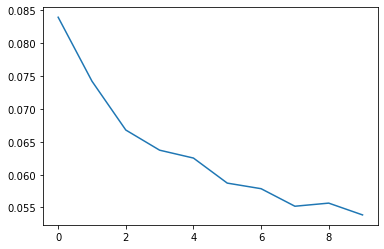

In [18]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

## denoising

In [130]:
dataset = TheDataSet(datafile=dataset_file)
print(f"dataset length = {len(dataset)} num features = {dataset.num_features()}")
model = Autoencoder(num_features=dataset.num_features())
print(model)
max_epochs = 150 #encoder_training_epochs

dataset length = 54871 num features = 1440
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1440, out_features=720, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=720, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=720, bias=True)
    (3): ReLU()
    (4): Linear(in_features=720, out_features=1440, bias=True)
    (5): ReLU()
  )
)


In [131]:
%%time


outputs, losses = train(model, dataset=dataset, num_epochs=max_epochs, batch_size = 256, learning_rate=1e-3, denosing=True, denoise_p=0.1)

.Loss:0.0437..........Loss:0.0194..........Loss:0.0183..........Loss:0.0157..........Loss:0.0166..........Loss:0.0154..........Loss:0.0156..........Loss:0.0153..........Loss:0.0155..........Loss:0.0159..........Loss:0.0160..........Loss:0.0145..........Loss:0.0175..........Loss:0.0167..........Loss:0.0155.........CPU times: user 21min 3s, sys: 48.8 s, total: 21min 52s
Wall time: 10min 56s


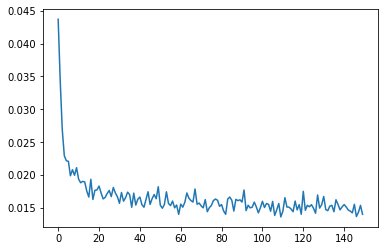

In [132]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

In [135]:
import config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np_cohort_data_file = config.DATA_DIR + '/' + 'raw_cohort_data.npy'
dataset = TheDataSet(datafile=np_cohort_data_file)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
rows=[]
for X, y in data_loader:
    X = X.to(device)
    y = y.to(device)
    row = model.encoder(X.float())
    row = torch.cat([row.reshape(1,-1),y.reshape(1,-1).float()], dim=1)
    rows.append(row)

In [136]:
len(rows)

6391

In [137]:
encoded_data = torch.cat(rows, dim=0)

In [140]:
encoded_data.shape

torch.Size([6391, 65])

In [141]:
np_labeled_data = encoded_data.detach().to('cpu').numpy()

In [142]:
np.save('data/autoencoded_fulldata.npy', np_labeled_data)

In [20]:
np.save('data/np_autoencoded_labeled_data.npy', np_labeled_data)

In [34]:
row.reshape(1,-1).shape, torch.cat([row.reshape(1,-1),y.reshape(1,-1).float()], dim=1)

(torch.Size([1, 65]),
 tensor([[ 0.1479, -0.2890, -0.5155, -0.3377, -0.1543,  0.9087,  0.3199, -0.0341,
          -0.6982,  0.9970,  0.3223, -0.0421, -0.2520,  0.6466, -0.0977,  0.2991,
           0.8181,  0.4294, -0.0431, -0.3838,  0.9970,  0.6513, -0.9836,  0.9970,
           0.2387, -0.9970,  0.9970, -0.1760, -0.5356, -0.8139, -0.4584, -0.3392,
           0.0995,  0.9159, -0.9970,  0.0716, -0.1129,  0.4067,  0.9970, -0.4828,
           0.8070,  0.1122,  0.0312, -0.9970,  0.0856, -0.1463, -0.9970,  0.3189,
           0.8918,  0.1904,  0.9970, -0.9951, -0.5434,  0.1786, -0.7900, -0.5141,
           0.3048, -0.8398, -0.9355,  0.1171,  0.8686,  0.2800,  0.4023, -0.3393,
           0.0000,  0.0000]], device='cuda:0', grad_fn=<CatBackward>))

In [ ]:
import numpy as np
np.save()

In [41]:
min(losses)

0.009168824180960655

In [133]:
# persist the encoder


with open('data/autoencoder.pic', 'bw') as f:
    torch.save(model, f, pickle_protocol=4)




In [10]:
with open('data/autoencoder.pic', 'rb') as f:
    autoencoder = torch.load(f)